In [2]:
import os
import pandas as pd
import numpy as np
from skimage import color
from PIL import Image
from skimage.color import rgb2lab

In [3]:
from analyzer import AppliedImageAnalyzer, IT8Analyzer
import pandas as pd

In [4]:
analyzer = AppliedImageAnalyzer("Applied Image Slide.tif")
ai_processed = analyzer.process()
pd.DataFrame(ai_processed)['delta'].mean()

np.float64(16.0552)

In [4]:
analyzer = AppliedImageAnalyzer("Applied Image Slide_icc.tif")
ai_processed = analyzer.process()
pd.DataFrame(ai_processed)['delta'].mean()

np.float64(3.9704)

In [5]:
analyzer2 = IT8Analyzer("IT8 E130102.tif", "IT8 Reference File E130102.txt")
it8_processed = analyzer2.process()
pd.DataFrame(it8_processed)['delta'].mean()

np.float64(13.744826388888889)

In [6]:
analyzer2 = IT8Analyzer("IT8 E130102_icc.tif", "IT8 Reference File E130102.txt")
it8_processed = analyzer2.process()
pd.DataFrame(it8_processed)['delta'].mean()

np.float64(2.0491319444444445)

In [1]:
from CEL_GOG_Matrix_Conversion_1113 import transform_img

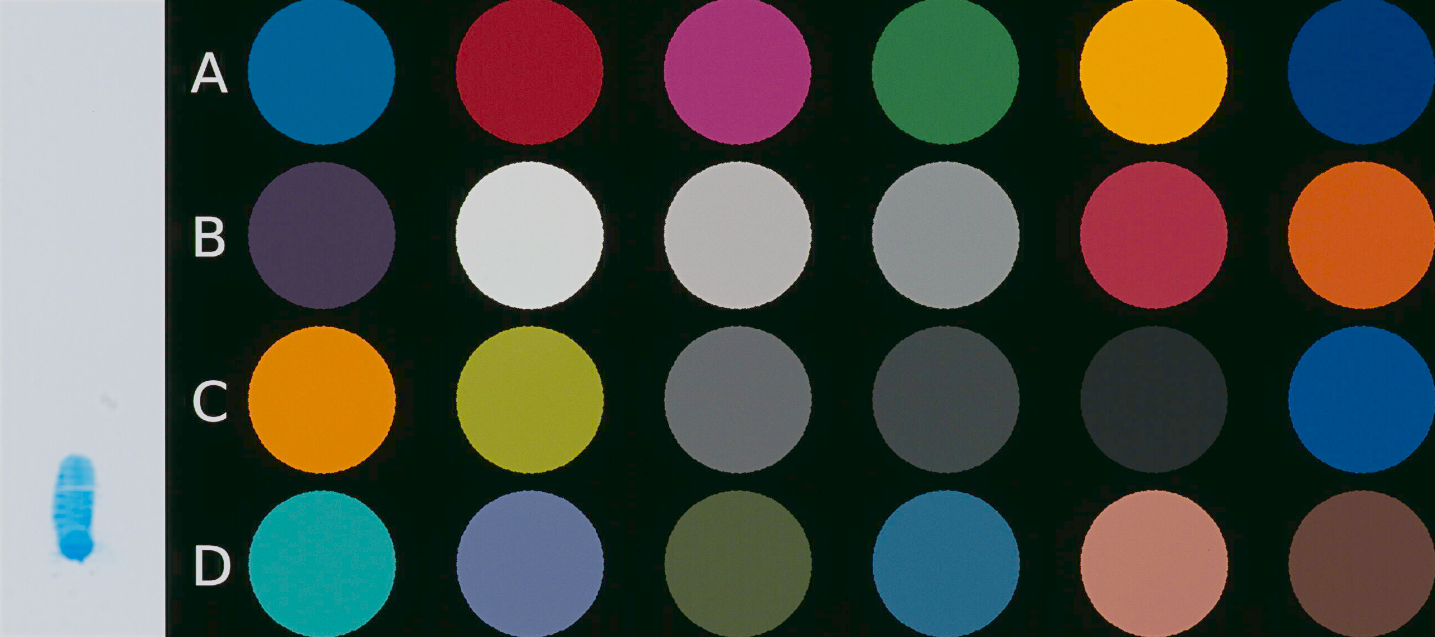

In [8]:
Image.fromarray(transform_img(np.array(analyzer.slide)))